In [1]:
import os
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn


In [2]:
import wandb

wandb.login()
wandb.init(
    project="cv_ass1", 
    name=f"Q2_Resnet", 
    config={
    "learning_rate": 0.001,
    "architecture": "CNN",
    "dataset": "Russian Wildlife Dataset",
    "epochs": 10,
    })

config = wandb.config   

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: utsav21108 (utsv-grg). Use `wandb login --relogin` to force relogin


In [3]:
label_map = {'black_bear': 0, 'people': 1, 'birds': 2, 'dog': 3, 'brown_bear': 4, 'roe_deer': 5, 'wild_boar': 6, 'amur_tiger': 7, 'amur_leopard': 8, 'sika_deer': 9}
target_size = (224,224)

In [4]:
weights = ResNet18_Weights.DEFAULT
preprocess = weights.transforms()
model = resnet18(weights=weights)
model.fc = nn.Linear(512,10,bias=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
class RussianWildlifeDataset(Dataset):

    def __init__(self, img_dir):

        self.img_dir = img_dir
        self.data_list = []
        for label in os.listdir(self.img_dir):
            for file in os.listdir(os.path.join(self.img_dir,label)):
                self.data_list.append((file,label))

    def __len__(self):

        return len(self.data_list)

    def __getitem__(self, idx):

        file_name, label = self.data_list[idx]
        img_path = os.path.join(self.img_dir, label, file_name)
        img = read_image(img_path)
        img = preprocess(img)
        return img, label_map[label]

In [6]:
data = RussianWildlifeDataset('data')
print(len(data))

12825


In [7]:
train_size = int(0.7 * len(data))
val_size = int(0.1 * len(data))
test_size = len(data) - train_size - val_size

train_set, val_set, test_set = random_split(data, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=8)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=8)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=8)

print(len(train_set), len(val_set), len(test_set))

8977 1282 2566


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
n_epoch = 10
save_loss = 99999

print("Started Training")

for epoch in range(n_epoch):
    print('Training for epoch: ', epoch)

    model.train()
    tloss = 0
    tstep = 0

    for i, data in enumerate(train_loader, 0):
        img, label = data
        inputs = img.to(device)
        labels = label.to(device)
        optimizer.zero_grad()

        inputs = inputs.squeeze(1)
        outputs = model(inputs)

        train_loss =  criterion(outputs, labels)
        train_loss.backward()
        optimizer.step()
        tstep+=1
        tloss += train_loss.item()

    tstep+=1
    print('EPOCH:',epoch)
    print('Average train loss:', tloss/tstep)

    model.eval()
    vloss = 0
    vstep = 0

    for i, data in enumerate(val_loader, 0):
        img, label = data
        inputs = img.to(device)
        labels = label.to(device)

        inputs = inputs.squeeze(1)
        outputs = model(inputs)

        val_loss =  criterion(outputs, labels)
        vstep+=1
        vloss += val_loss.item()

    vstep+=1
    print('Average val loss:', vloss/vstep)
    if(vloss/vstep<save_loss):
        save_loss = vloss/vstep
        state = {'model': model.state_dict(), 'optimizer': optimizer.state_dict()}
        torch.save(state, 'q2_resnet_best.pt')  

    log_metric = {"Epoch":epoch, "Train Loss": tloss/tstep, "Val Loss": vloss/vstep}
    wandb.log(log_metric)
        
print("Finished Training")

Started Training
Training for epoch:  0
EPOCH: 0
Average train loss: 1.0556671603562984
Average val loss: 0.9650225795450664
Training for epoch:  1
EPOCH: 1
Average train loss: 0.6905027204160149
Average val loss: 0.7942034261567252
Training for epoch:  2
EPOCH: 2
Average train loss: 0.5064740311486501
Average val loss: 0.7844162072759078
Training for epoch:  3
EPOCH: 3
Average train loss: 0.4022998444418958
Average val loss: 0.735050210640544
Training for epoch:  4
EPOCH: 4
Average train loss: 0.31231757969403945
Average val loss: 0.7088772805318946
Training for epoch:  5
EPOCH: 5
Average train loss: 0.25202702022164214
Average val loss: 0.597333097719543
Training for epoch:  6
EPOCH: 6
Average train loss: 0.221102187409997
Average val loss: 0.6825073936155864
Training for epoch:  7
EPOCH: 7
Average train loss: 0.1580125565561367
Average val loss: 0.6347895759446103
Training for epoch:  8
EPOCH: 8
Average train loss: 0.11987939808874372
Average val loss: 0.7144115276279903
Training fo

In [10]:
state = {'model': model.state_dict(), 'optimizer': optimizer.state_dict()}
torch.save(state, 'q2_resnet.pt')

The train loss keeps on reducing on training after each epoch which is expected, but after epoch 4. The val loss starts increasing which increase to 2.03. Thus the model is overtrained now
Only keeping the train limited to 5 epochs would have been ideal.

In [17]:
#In case best model is to be runned.
model = resnet18()
model.fc = nn.Linear(512,10,bias=True)
state_dict = torch.load('q2_resnet_best.pt')
model.load_state_dict(state_dict['model'])

<All keys matched successfully>

In [18]:
print("Started Testing")

test_labels = []
test_predictions = []

model.eval()

with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        img, labels = data
        test_labels.extend(labels.numpy())

        inputs = img.to(device)
        inputs = inputs.squeeze(1)
        
        outputs = model(inputs).argmax(dim=1)
        test_predictions.extend(outputs.numpy())
        
print("Finished Testing")

Started Testing
Finished Testing


In [19]:
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix

test_labels = np.array(test_labels)
test_predictions = np.array(test_predictions)


correct = (test_labels==test_predictions).sum()
total = len(test_predictions)

acc = correct/total
f1score = f1_score(test_labels,test_predictions,average='macro')

print("Accuracy: ", acc)
print("F1 Score: ", f1score)

cm = confusion_matrix(test_labels, test_predictions)
# wandb.log({"Accuracy":acc, "F1 Score":f1score})
print(cm)

Accuracy:  0.8347622759158223
F1 Score:  0.8337948738866295
[[134   0   5   4  52   1  11   1   1   2]
 [  0 247   7  11   3   8   2   4   2   8]
 [  3   2 267  18   3   1   6   3   1   5]
 [  4   2   7 195   5   7   6   7   1  16]
 [ 26   1   5   5 211   2  16   1   2   1]
 [  0   0   1   2   1 194   2   0   0   9]
 [  1   0   3   3   8   6 243   0   0   4]
 [  0   0   5  11   6   1   3 195   3   5]
 [  0   0   1   2   3   0   2   0 219   0]
 [  1   2  10  10   5  24   9   3   0 237]]


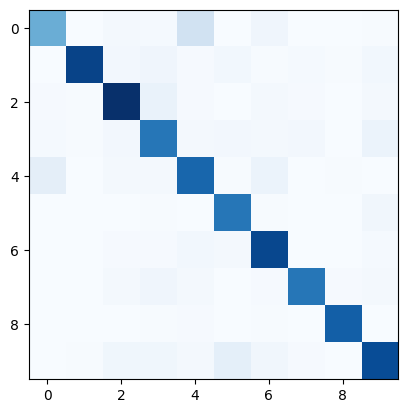

In [20]:
plt.imshow(cm, cmap='Blues')
plt.show(plt)
# wandb.log({"Confusion Matrix": wandb.Image(plt)})

In [15]:
wandb.finish()

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
F1 Score,▁
Train Loss,█▅▄▃▂▂▂▁▁▁
Val Loss,█▅▅▄▃▁▃▂▃▄
Accuracy,0.81645
Epoch,9
F1 Score,0.81725
Train Loss,0.12378
Val Loss,0.77096
